In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.imports import *
from lib.utils import *
from lib.functions import *

In [3]:
torch.__version__

'1.5.1'

In [4]:
torch_geometric.__version__

'1.5.0'

In [9]:
device = 'cpu'
ckpt = 'edge_pred_2.pt'

In [10]:
class EdgePredictor(nn.Module):
    def __init__(self, num_blocks=3):
        super().__init__()
        
        self.in_blocks = nn.ModuleList([
            GNNBlockForEdgePrediction(feat_dims=[2, 8], bn=True, dp=0.2, n_edge_attr=2)
        ])
        self.hid_blocks = nn.ModuleList([
            GNNBlockForEdgePrediction(feat_dims=[8, 16, 16, 8], 
                     efeat_hid_dims=[16],
                     bn=True, 
                     act=True,
                     dp=0.2, 
                     n_edge_attr=2,
                     residual=True)
            for _ in range(num_blocks)
        ])
        self.out_blocks = nn.ModuleList([
            GNNBlockForEdgePrediction(feat_dims=[8, 8], act=False, n_edge_attr=2)
        ])

    def forward(self, data):
        x = data.pos
        e = data.edge_index
        label = data.y
        for block in chain(self.in_blocks, 
                           self.hid_blocks, 
                           self.out_blocks):
            x = block(x, data)
        prob = F.cosine_similarity(x[e[0]], x[e[1]]).add(1).div(2)
        pos = label.eq(1)
        neg = label.eq(0)
        pos_w = neg.sum().float().div(len(label))
        neg_w = pos.sum().float().div(len(label))
        w = pos * pos_w + neg * neg_w
        loss = (prob - label).square().mul(w).mean()
        return loss, prob

In [11]:
class RandomEdgePredictor(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

    def forward(self, data):
        x = data.pos
        e = data.edge_index
        prob = torch.rand(e.size()[1]).type_as(x)
        loss = None
        return loss, prob

In [12]:
def rescale_with_normalized_density(pos):
    pos = (pos.sub(pos.mean(dim=0))
              .div(pos.std(dim=0).mean())
              .mul(np.sqrt(pos.size()[0])))
    return pos

In [13]:
def generate_data(G):
    i, j = np.meshgrid(*([np.arange(G.number_of_nodes())] * 2))
    pos = np.array(list(nx.nx_agraph.graphviz_layout(G, prog='neato').values()))
    node_pos = rescale_with_normalized_density(torch.tensor(pos, dtype=torch.float32).to(device))
    edge_feat = torch.tensor(pos[j] - pos[i], dtype=torch.float32).to(device)
    edge_label = torch.tensor(nx.to_numpy_matrix(G), dtype=torch.float32).to(device)
    return nx_to_tg(G=G, 
                    pos=node_pos,
                    edge_feat=edge_feat,
                    edge_label=edge_label)

In [ ]:
datafiles = glob.glob("data/rome/*.graphml") 
G_list = [nx.read_graphml(datafile) for datafile in tqdm(datafiles)] 
data_list = [generate_data(G) for G in tqdm(G_list)]
torch.save(data_list, open('data_list_datagen.pickle', 'wb'))
torch.save(G_list, open('G_list_datagen.pickle', 'wb'))

In [14]:
data_list = torch.load(open('data_list_datagen.pickle', 'rb'), map_location=torch.device(device))
G_list = torch.load(open('G_list_datagen.pickle', 'rb'), map_location=torch.device(device))

In [6]:
loader = DataLoader(data_list, batch_size=128, shuffle=True)

In [15]:
state_dict = torch.load(open(ckpt, "rb"), map_location=torch.device(device))
model = EdgePredictor().to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [41]:
model = EdgePredictor().to(device)

In [25]:
rand_model = RandomEdgePredictor().to(device)

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [10]:
real_epoch = 0

In [61]:
for epoch in range(9999):
    real_epoch += 1
    model.train()
    loss_all, acc_all, prec_all, rec_all, f1_all = [], [], [], [], []
    for itr, batch in enumerate(tqdm(loader)):
        batch = batch.to(device)
        optimizer.zero_grad()
        loss, prob = model(batch)
        loss.backward()
        optimizer.step()
        pred = (prob > 0.5).long()
        label = batch.y
        accuracy = metrics.accuracy_score(label.detach().cpu(), pred.detach().cpu())
        precision = metrics.precision_score(label.detach().cpu(), pred.detach().cpu())
        recall = metrics.recall_score(label.detach().cpu(), pred.detach().cpu())
        f1 = metrics.f1_score(label.detach().cpu(), pred.detach().cpu())
        loss_all += [loss.item()]
        acc_all += [accuracy]
        prec_all += [precision]
        rec_all += [recall]
        f1_all += [f1]
        if itr % 1 == 0:
            print(f'loss: {loss.item():.4f}, accuracy: {accuracy:.2f}, precision: {precision:.2f}, recall: {recall:.2f}, f1: {f1:.2f}')
#             p, r, t = metrics.precision_recall_curve(label.cpu().numpy(), logits.detach().cpu().numpy())
#             plt.plot(p, r, 'o-')
#             plt.show()
    print(f'[{real_epoch}] loss: {np.mean(loss_all):.4f}, accuracy: {np.mean(acc_all):.2f}, precision: {np.mean(prec_all):.2f}, recall: {np.mean(rec_all):.2f}, f1: {np.mean(f1_all):.2f}', file=open('edge_pred.log', 'a'))
    torch.save(model.state_dict(), open(ckpt, 'wb'))
    scheduler.step()

loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2453, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2447, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2468, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2477, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2465, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2445, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2458, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2468, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2454, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2459, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2483, accura

loss: 0.2467, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2469, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2448, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2463, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2462, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2450, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2439, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2465, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2427, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2479, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2471, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2470, accura

loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2474, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2471, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2436, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2472, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2447, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2472, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2473, accura

loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2478, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2474, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2446, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2466, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2463, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2443, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2482, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.19
loss: 0.2476, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2459, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2463, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2471, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2466, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2428, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2464, accura

loss: 0.2476, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2434, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2447, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2439, accuracy: 0.70, precision: 0.13, recall: 0.98, f1: 0.22
loss: 0.2439, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2478, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2469, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2461, accura

loss: 0.2452, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2465, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2448, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2435, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2444, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2451, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2476, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2466, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2471, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2450, accura

loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2445, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2450, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2448, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2452, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2443, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2443, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2460, accura

loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2467, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2438, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2452, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2443, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2452, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2470, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2462, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2450, accura

loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2456, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2464, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2446, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2465, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2423, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2476, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2450, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2462, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2456, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2453, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2467, accura

loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2465, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2467, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2467, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2433, accuracy: 0.69, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2468, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2453, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2448, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2451, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2454, accura

loss: 0.2462, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2468, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2447, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2463, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2465, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2428, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2474, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2466, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2437, accuracy: 0.69, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2466, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2459, accura

loss: 0.2438, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2444, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2456, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2436, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2443, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2453, accura

loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2463, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2436, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2435, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2434, accuracy: 0.70, precision: 0.13, recall: 0.98, f1: 0.23
loss: 0.2464, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2450, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2465, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2472, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2446, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2440, accura

KeyboardInterrupt: 

In [16]:
def augment_graph(G, model):
    m = random.randrange(1, G.number_of_nodes() // 4)
    n = random.randrange(1, G.number_of_nodes() // 4)
    k = random.randrange(1, G.number_of_edges() // 4)
    l = random.randrange(1, G.number_of_edges() // 4)
    
    augmented_G = G.copy()
    for node in random.choices(list(augmented_G.nodes()), k=m):
        if node in augmented_G:
            edges = [(node, nb) for nb in augmented_G.adj[node].keys()]
            augmented_G.remove_node(node)
            if not nx.algorithms.components.is_connected(augmented_G):
                augmented_G.add_node(node)
                augmented_G.add_edges_from(edges)
    
    data = nx_to_tg(G)

    real_edge = data.real_edge_index[:, data.real_edge_index[0] < data.real_edge_index[1]].to(device)

    start_index, end_index = list(real_edge)
    new_end_index = torch.tensor(data.num_nodes + np.arange(n)).type_as(start_index)
    new_start_index = torch.tensor(random.choices(start_index, k=n)).type_as(end_index)
    start_index = torch.cat([start_index, new_start_index])
    end_index = torch.cat([end_index, new_end_index])
    data.real_edge_index = torch.stack([start_index, end_index])
    data = generate_data(tg_to_nx(data))

    real_edge = data.real_edge_index[:, data.real_edge_index[0] < data.real_edge_index[1]].to(device)
    full_edge = data.edge_index[:, data.edge_index[0] < data.edge_index[1]].to(device)

    loss, prob = model(data.to(device))
    placeholder = torch.zeros(data.num_nodes).diag().to(device)
    adjacency = placeholder.index_put(list(data.edge_index), prob)
    full_mask = placeholder.index_put(list(full_edge), torch.ones(1).to(device))
    edge_mask = placeholder.index_put(list(real_edge), torch.ones(1).to(device))
    nonedge_mask = full_mask - edge_mask
    top_nonedge_idx = adjacency.mul(nonedge_mask)[list(full_edge)].argsort(descending=True)
    selected_k = top_nonedge_idx[:k]
    top_k_edges = full_edge.index_select(1, selected_k)
    bottom_edge_idx = adjacency.mul(edge_mask)[list(real_edge)].argsort(descending=False)
    selected_l = bottom_edge_idx[:l]
    bottom_l_edges = real_edge.index_select(1, selected_l)
    data.real_edge_index = torch.cat([real_edge, top_k_edges], dim=1)

    augmented_G = tg_to_nx(data)
    for u, v in bottom_l_edges.T.tolist():
        augmented_G.remove_edge(u, v)
        if not nx.algorithms.components.is_connected(augmented_G):
            augmented_G.add_edge(u, v)
    return augmented_G

In [11]:
init_t = time.time()
idx_range = range(len(G_list))
for i in tqdm(idx_range):
    for j in range(10):
        try:
            aug_G = torch.load(open(f'augmentation-top-k/G_list_{i}_{j}.pickle' ,'rb'))
            torch.save(G_to_data(aug_G), open(f'augmentation-top-k/data_list_{i}_{j}.pickle' ,'wb'))
        except:
            pass
    print(f'{i}/{len(G_list)} {time.time() - init_t:.2f}', file=open('augmentation-top-k.log', 'a'))

In [ ]:
init_t = time.time()
idx_range = range(9000, len(G_list))
for i in tqdm(idx_range):
    for j in range(10):
        try:
            aug_G = augment_graph(G_list[i], model)
            torch.save(aug_G, f'augmentation-top-k/G_list_{i}_{j}.pickle')
            torch.save(G_to_data(aug_G), f'augmentation-top-k/data_list_{i}_{j}.pickle')
        except:
            pass
    print(f'{i}/{len(G_list)} {time.time() - init_t:.2f}', file=open('augmentation-top-k.log', 'a'))

/opt/conda/lib/python3.7/site-packages/torch_geometric/data/data.py:198: UserWarning: The number of nodes in your data object can only be inferred by its edge indices, and hence may result in unexpected batch-wise behavior, e.g., in case there exists isolated nodes. Please consider explicitly setting the number of nodes for this data object by assigning it to data.num_nodes.
  warnings.warn(__num_nodes_warn_msg__.format('edge'))


In [18]:
init_t = time.time()
idx_range = range(len(G_list))
G_list_aug = []
data_list_aug = []
for i in tqdm(idx_range):
    for j in range(10):
        try:
            data = torch.load(f'augmentation-top-k/data_list_{i}_{j}.pickle')
            G = torch.load(f'augmentation-top-k/G_list_{i}_{j}.pickle')
            data_list_aug.append(data)
            G_list_aug.append(G)
        except:
            print(i, j)
torch.save(G_list_aug, 'G_list_augmented_top-k.pickle')
torch.save(data_list_aug, 'data_list_augmented_top-k.pickle')

6418 0
6418 1
6418 2
6418 3
6418 4
6418 5
6418 6
6418 7
6418 8
6418 9
8465 0
8465 1
8465 2
8465 3
8465 4
8465 5
8465 6
8465 7
8465 8
8465 9



In [ ]:
init_t = time.time()
for i, G in enumerate(tqdm(G_list[10400:])):
    for j in range(10):
        aug_G = augment_graph(G, model)
        torch.save(aug_G, open(f'augmentation-top-k/G_list_{i}_{j}.pickle' ,'wb'))
        torch.save(G_to_data(aug_G), open(f'augmentation-top-k/data_list_{i}_{j}.pickle' ,'wb'))
    print(f'{i+10400}/{len(G_list)} {time.time() - init_t:.2f}', file=open('augmentation-top-k.log', 'a'))

/opt/conda/lib/python3.7/site-packages/torch_geometric/data/data.py:198: UserWarning: The number of nodes in your data object can only be inferred by its edge indices, and hence may result in unexpected batch-wise behavior, e.g., in case there exists isolated nodes. Please consider explicitly setting the number of nodes for this data object by assigning it to data.num_nodes.
  warnings.warn(__num_nodes_warn_msg__.format('edge'))


In [ ]:
init_t = time.time()
for i, G in enumerate(tqdm(G_list)):
    for j in range(10):
        aug_G = torch.load(open(f'augmentation-top-k/G_list_{i}_{j}.pickle' ,'rb'))
        torch.save(G_to_data(aug_G), open(f'augmentation-top-k/data_list_{i}_{j}.pickle' ,'wb'))
    print(f'{i}/{len(G_list)} {time.time() - init_t:.2f}', file=open('augmentation-top-k.log', 'a'))

In [ ]:
augmented_G_list = []
augmented_data_list = []
for G in tqdm(G_list):
    for _ in range(9):
        aug_G = augment_graph(G, model)
        augmented_G_list.append(aug_G)
        augmented_data_list.append(G_to_data(aug_G))
torch.save(augmented_G_list, open('G_list_augmented_top-k.pickle' ,'wb'))
torch.save(augmented_data_list, open('data_list_augmented_top-k.pickle' ,'wb'))

In [8]:
init_t = time.time()
idx_range = range(len(G_list))
for i in tqdm(idx_range):
    for j in range(10):
        try:
            open(f'augmentation-top-k/G_list_{i}_{j}.pickle', 'r')
        except:
            print(i, j)

9099 0
9099 1
9099 2
9099 3
9099 4
9099 5
9099 6
9099 7
9099 8
9099 9
9100 0
9100 1
9100 2
9100 3
9100 4
9100 5
9100 6
9100 7
9100 8
9100 9
9101 0
9101 1
9101 2
9101 3
9101 4
9101 5
9101 6
9101 7
9101 8
9101 9
9102 0
9102 1
9102 2
9102 3
9102 4
9102 5
9102 6
9102 7
9102 8
9102 9
9103 0
9103 1
9103 2
9103 3
9103 4
9103 5
9103 6
9103 7
9103 8
9103 9
9104 0
9104 1
9104 2
9104 3
9104 4
9104 5
9104 6
9104 7
9104 8
9104 9
9105 0
9105 1
9105 2
9105 3
9105 4
9105 5
9105 6
9105 7
9105 8
9105 9
9106 0
9106 1
9106 2
9106 3
9106 4
9106 5
9106 6
9106 7
9106 8
9106 9
9107 0
9107 1
9107 2
9107 3
9107 4
9107 5
9107 6
9107 7
9107 8
9107 9
9108 0
9108 1
9108 2
9108 3
9108 4
9108 5
9108 6
9108 7
9108 8
9108 9
9109 0
9109 1
9109 2
9109 3
9109 4
9109 5
9109 6
9109 7
9109 8
9109 9
9110 0
9110 1
9110 2
9110 3
9110 4
9110 5
9110 6
9110 7
9110 8
9110 9
9111 0
9111 1
9111 2
9111 3
9111 4
9111 5
9111 6
9111 7
9111 8
9111 9
9112 0
9112 1
9112 2
9112 3
9112 4
9112 5
9112 6
9112 7
9112 8
9112 9
9113 0
9113 1
9113 2

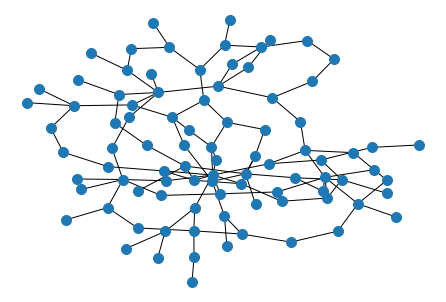

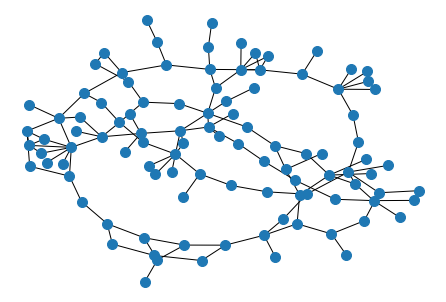

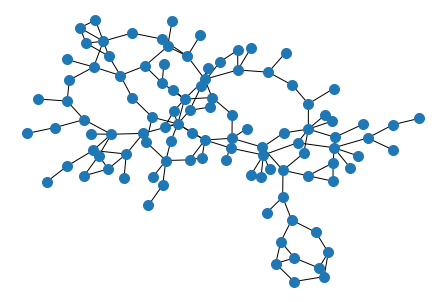

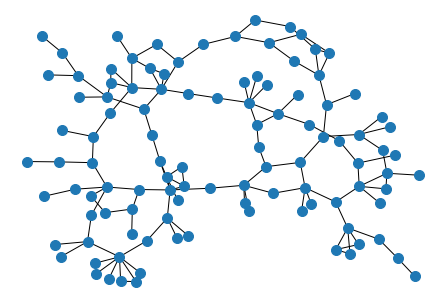

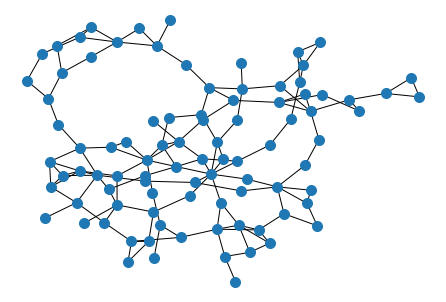

In [13]:
warnings.filterwarnings('ignore')
G = G_list[1000]
visualize_graph(generate_data(G))
visualize_graph(generate_data(augment_graph(G, model)))
visualize_graph(generate_data(augment_graph(G, model)))
visualize_graph(generate_data(augment_graph(G, model)))
visualize_graph(generate_data(augment_graph(G, model)))
# visualize_graph(generate_data(augment_graph(G, rand_model)))
# visualize_graph(generate_data(augment_graph(G, rand_model)))
# visualize_graph(generate_data(augment_graph(G, rand_model)))
# visualize_graph(generate_data(augment_graph(G, rand_model)))

In [13]:
torch_geometric.utils.to_networkx(data_list[0], to_undirected=True)

In [24]:
G_list[0]

EdgeView([('n0', 'n9'), ('n0', 'n11'), ('n1', 'n9'), ('n1', 'n6'), ('n2', 'n9'), ('n3', 'n16'), ('n4', 'n12'), ('n4', 'n13'), ('n4', 'n14'), ('n4', 'n17'), ('n5', 'n13'), ('n5', 'n10'), ('n5', 'n15'), ('n6', 'n10'), ('n7', 'n10'), ('n8', 'n15'), ('n11', 'n16')])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


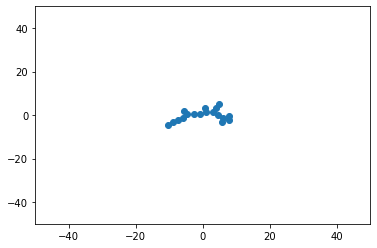

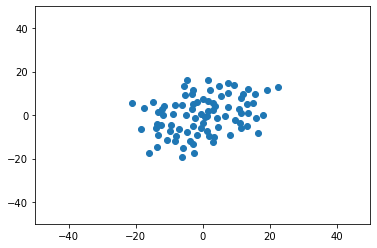

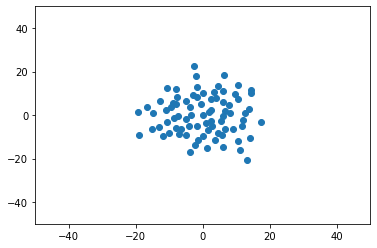

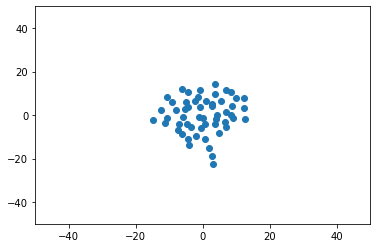

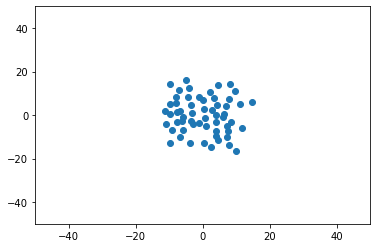

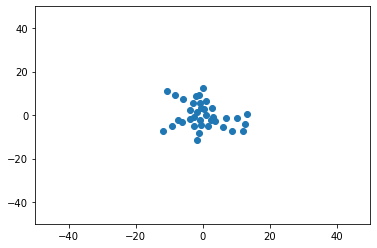

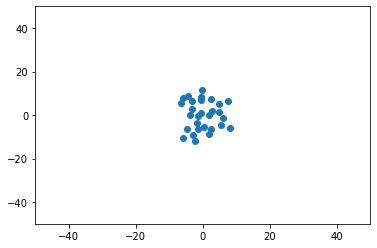

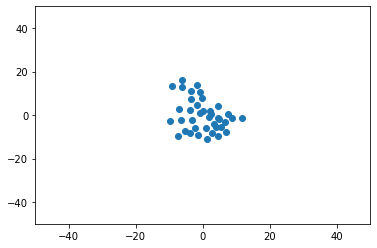

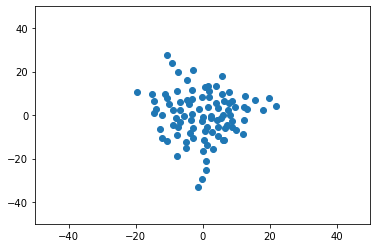

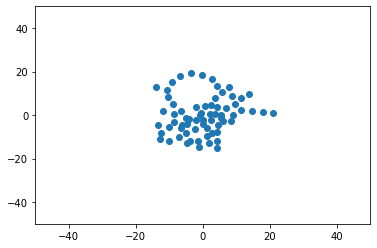

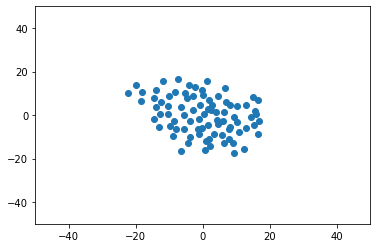

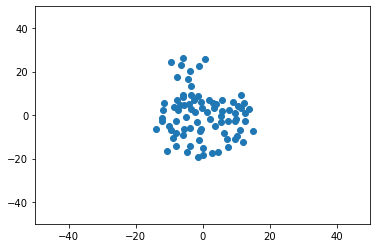

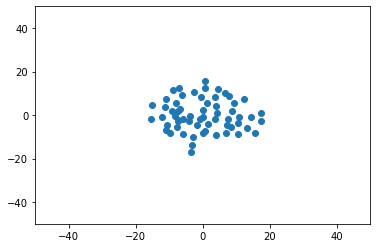

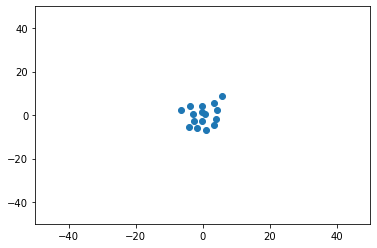

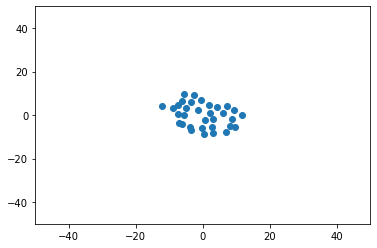

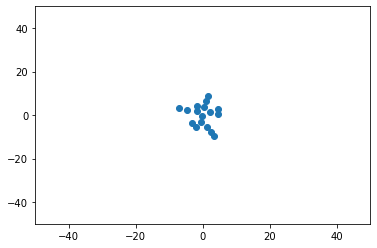

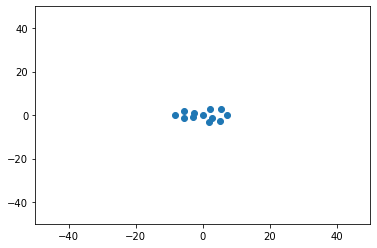

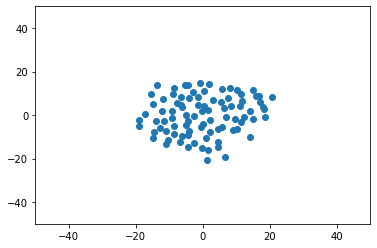

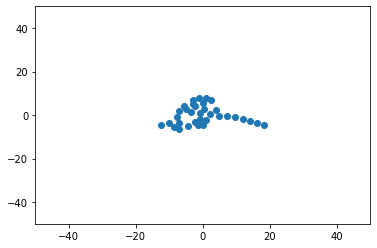

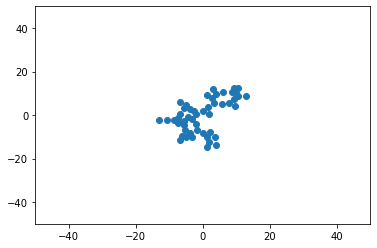

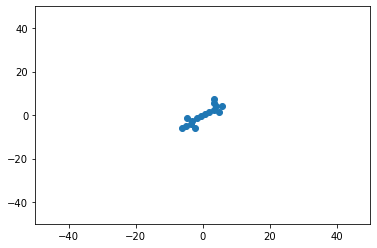

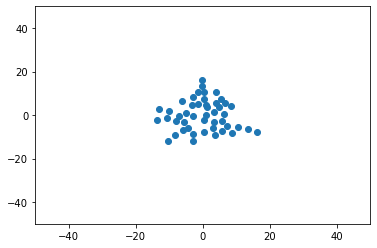

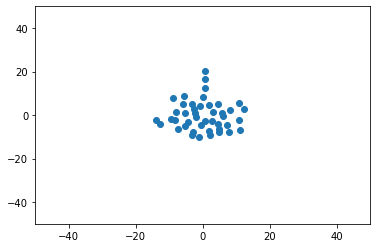

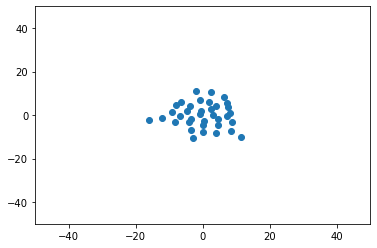

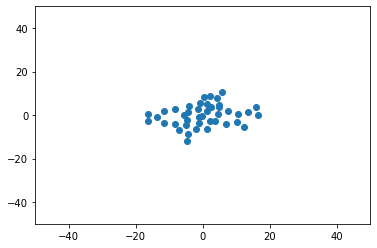

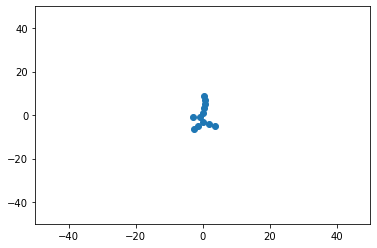

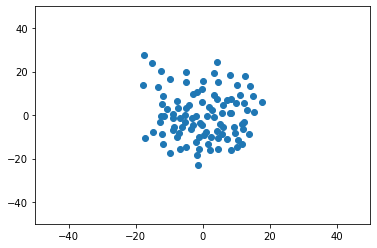

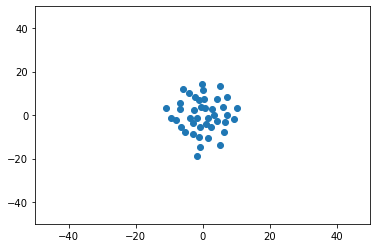

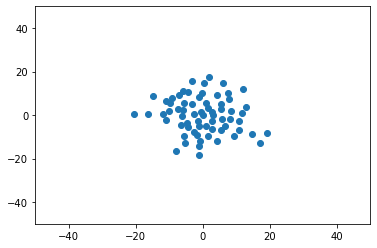

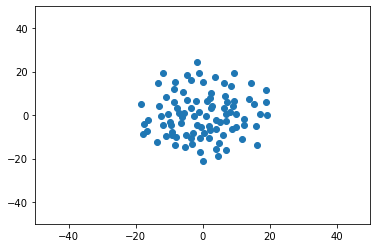

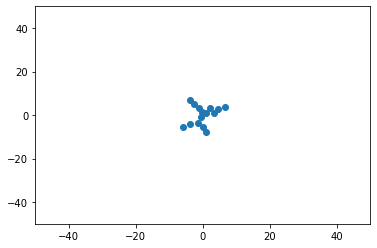

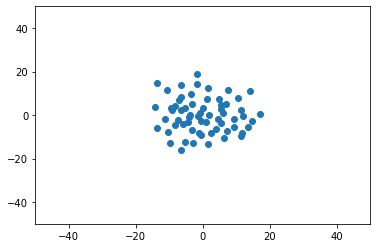

In [68]:
for i in range(32):
    p = data_list[i].pos
    x, y = p[:, 0], p[:, 1]

    lim = 50
    plt.figure()
    plt.scatter(x, y)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)